In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

torch.__version__

'1.9.0'

In [3]:
#!pip install pytorch_model_summary
from pytorch_model_summary import summary

### PyTorch Autoencoder - MNIST dataset

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True)

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /Users/mike/torch_datasets/MNIST/raw/train-images-idx3-ubyte.gz to /Users/mike/torch_datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /Users/mike/torch_datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /Users/mike/torch_datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /Users/mike/torch_datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /Users/mike/torch_datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /Users/mike/torch_datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /Users/mike/torch_datasets/MNIST/raw



/Users/mike/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
class AE(nn.Module):
    def __init__(self, input_shape):
        super(AE, self).__init__()
        self.encoder_hidden_layer = nn.Linear(
                                    in_features=input_shape, out_features=128)
        self.encoder_output_layer = nn.Linear(
                                    in_features=128, out_features=128)
        self.decoder_hidden_layer = nn.Linear(
                                    in_features=128, out_features=128)
        self.decoder_output_layer = nn.Linear(
                                    in_features=128, out_features=input_shape)

    def forward(self, features):
        a = self.encoder_hidden_layer(features)
        a = torch.relu(a)
        
        code = self.encoder_output_layer(a)
        code = torch.relu(code)
        
        a = self.decoder_hidden_layer(code)
        a = torch.relu(a)
        a = self.decoder_output_layer(a)
        reconstructed = torch.relu(a)
        return reconstructed

In [8]:
model = AE(784).to(device)
print(summary(model,torch.zeros((784,)).to(device)))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Linear-1               [128]         100,480         100,480
          Linear-2               [128]          16,512          16,512
          Linear-3               [128]          16,512          16,512
          Linear-4               [784]         101,136         101,136
Total params: 234,640
Trainable params: 234,640
Non-trainable params: 0
-----------------------------------------------------------------------


In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
epochs = 20

for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        batch_features = batch_features.view(-1, 784).to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    
    loss = loss / len(train_loader)
    print(f"epoch : {epoch + 1}/{epochs}, loss = {np.round(loss,5)}")

epoch : 1/20, loss = 0.03091
epoch : 2/20, loss = 0.0164
epoch : 3/20, loss = 0.01449
epoch : 4/20, loss = 0.01355
epoch : 5/20, loss = 0.01293
epoch : 6/20, loss = 0.01252
epoch : 7/20, loss = 0.01221
epoch : 8/20, loss = 0.01194
epoch : 9/20, loss = 0.01174
epoch : 10/20, loss = 0.01156
epoch : 11/20, loss = 0.0114
epoch : 12/20, loss = 0.01127
epoch : 13/20, loss = 0.01115
epoch : 14/20, loss = 0.01106
epoch : 15/20, loss = 0.01097
epoch : 16/20, loss = 0.01088
epoch : 17/20, loss = 0.01081
epoch : 18/20, loss = 0.01075
epoch : 19/20, loss = 0.01069
epoch : 20/20, loss = 0.01063


#### Extract some test examples to reconstruct

In [11]:

test_dataset = datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True)

test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)


with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784).to(device)
        reconstruction = model(test_examples)
        break

#### Plot Original and Reconstruction

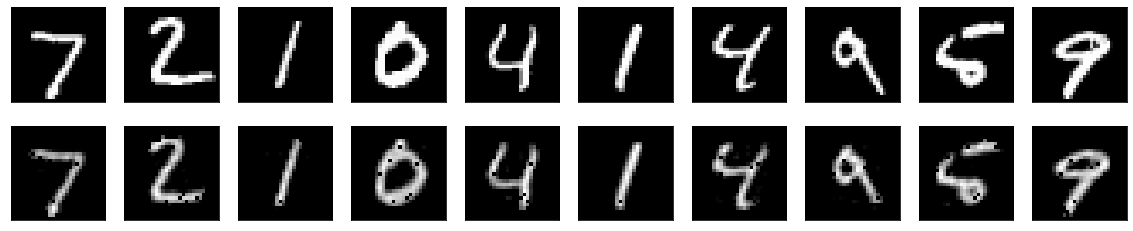

In [12]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].cpu().numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


### PyTorch Convolutional Autoencoder

In [13]:
#Converting data to torch.FloatTensor
transform = transforms.ToTensor()

# Download the training and test datasets
train_data = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)

test_data = datasets.CIFAR10(root='data', train=False, download=True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [14]:
#Prepare data loaders
train_loader = DataLoader(train_data, batch_size=32, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, num_workers=4)

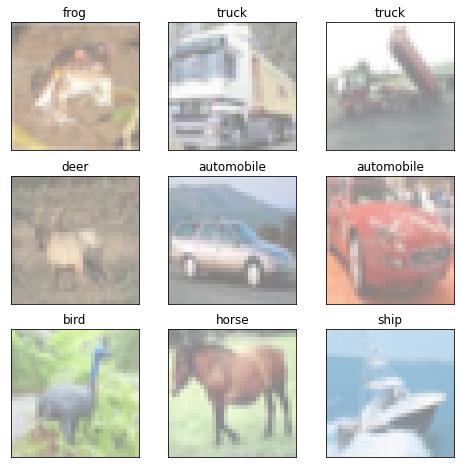

In [15]:
#Utility functions to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(np.transpose(img, (1, 2, 0))) 

 
#Define the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

#Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

#Plot the images
fig = plt.figure(figsize=(8, 8))
# display 9 images
for idx in np.arange(9):
    ax = fig.add_subplot(3, 3, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [16]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
       
        #Encoder
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)  
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
       
        #Decoder
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 3, 2, stride=2)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.t_conv1(x))
        x = torch.sigmoid(self.t_conv2(x))
              
        return x

In [17]:
#Instantiate the model
model = ConvAutoencoder().to(device)
print(model)

ConvAutoencoder(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 3, kernel_size=(2, 2), stride=(2, 2))
)


In [18]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [19]:
n_epochs = 10

for epoch in range(1, n_epochs+1):
    train_loss = 0.0

    for data in train_loader:
        images, _ = data
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
          
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

/Users/mike/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459044803/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 18.819238
Epoch: 2 	Training Loss: 18.273304
Epoch: 3 	Training Loss: 18.228786
Epoch: 4 	Training Loss: 18.202062
Epoch: 5 	Training Loss: 18.175923
Epoch: 6 	Training Loss: 18.147653
Epoch: 7 	Training Loss: 18.127441
Epoch: 8 	Training Loss: 18.114128
Epoch: 9 	Training Loss: 18.105740
Epoch: 10 	Training Loss: 18.100683


In [20]:
#Plot the images
def plot_im(images):
  fig = plt.figure(figsize=(8, 8))
  # display 5 images
  for idx in np.arange(5):
      ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
      imshow(images[idx])
      ax.set_title(classes[labels[idx]])

Original Images


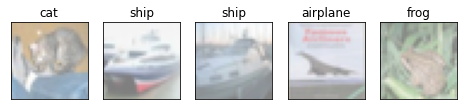

In [21]:
#Batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

#Sample outputs
output = model(images.to(device))
images = images.cpu().numpy()

output = output.view(32, 3, 32, 32)
output = output.detach().cpu().numpy()

#Original Images
print("Original Images")
plot_im(images)


Reconstructed Images


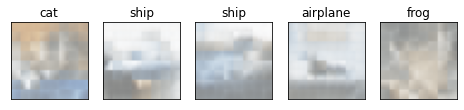

In [22]:
#Reconstructed Images
print('Reconstructed Images')
plot_im(output)